In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadr
from scipy.stats import pearsonr, spearmanr, kendalltau, fisher_exact, ttest_ind, sem, binom
from helpers import plot_params
from natsort import natsorted, natsort_keygen

## Load data

In [2]:
# Human data from Gerstenberg
human_responsibility = pyreadr.read_r('data/exp1_responsibility.RData')['df.exp1.responsibility']
human_prediction = pyreadr.read_r('data/exp1_prediction.RData')['df.exp1.prediction']

In [3]:
# Load data from our own collected .csv file
subjects = ["FUYU", "OTTER", "ADAPTER", "GPT-4V", "CLAUDE-3"]
models = pd.read_csv("data/JENGA_RESULTS_REV2.csv", sep=";").loc[:, :subjects[-1]]
num_seqs = models.Image.unique().shape[0]
models.head()

,Image,Experiment,Condition,GT,GPT-4V,FUYU,ADAPTER,OTTER,CLAUDE-3
0,1,1,counting,7.0,7,4.0,10,12,6
1,2,1,counting,7.0,10,4.0,10,12,7
2,3,1,counting,8.0,10,4.0,10,12,7
3,4,1,counting,9.0,10,4.0,5,12,7
4,5,1,counting,12.0,13,8.0,10,12,12


### 1. Analyze match to ground truth for counting

In [189]:
counting = np.zeros(len(subjects))
counting_errs = np.zeros(len(subjects))
gt = models[models.Experiment == 1]["GT"]
counting_errs_subj = np.zeros((len(subjects), len(gt)))

# Loop through subjects
for ind, subject in enumerate(subjects):  

        model_answers = models[models.Experiment == 1][subject]
        counting[ind] = np.nanmean(np.abs(model_answers.values - gt.values))
        counting_errs[ind] = sem(np.abs(model_answers.values - gt.values), nan_policy="omit")
        counting_errs_subj[ind] = np.abs(model_answers.values - gt.values)
        print(f"Counting, {subject}: {counting[ind]:.4f} mean absolute error")

Counting, FUYU: 4.2619 mean absolute error
Counting, OTTER: 2.7857 mean absolute error
Counting, ADAPTER: 3.8095 mean absolute error
Counting, GPT-4V: 2.0238 mean absolute error
Counting, CLAUDE-3: 1.3333 mean absolute error


### 2. Analyze match to ground truth for number of falling blocks

In [190]:
falling_gt = np.zeros(len(subjects)+1)
falling_gt_errs = np.zeros(len(subjects)+1)
gt = models[models.Experiment == 2]["GT"]

# Loop through subjects
for ind, subject in enumerate(subjects):  

        model_answers = models[models.Experiment == 2][subject]
        falling_gt[ind] = np.nanmean(np.abs(model_answers.values - gt.values))
        falling_gt_errs[ind] = sem(np.abs(model_answers.values - gt.values), nan_policy="omit")
        falling_gt_errs_subj[ind] = np.abs(model_answers.values - gt.values)
        print(f"Falling, {subject}: {falling_gt[ind]:.4f} mean absolute error to ground truth")

# Add human to human comparison
falling_gt[-1] = np.nanmean(np.abs(human_prediction.response - human_prediction.nfall))
falling_gt_errs[-1] = sem(np.abs(human_prediction.response - human_prediction.nfall), nan_policy="omit")
print(f"Falling, Human: {falling_gt[-1]:.4f} mean absolute error to ground truth")

Falling, FUYU: 2.4878 mean absolute error to ground truth
Falling, OTTER: 8.2683 mean absolute error to ground truth
Falling, ADAPTER: 9.7317 mean absolute error to ground truth
Falling, GPT-4V: 3.3902 mean absolute error to ground truth
Falling, CLAUDE-3: 4.6341 mean absolute error to ground truth
Falling, Human: 2.6751 mean absolute error to ground truth


In [191]:
# Calculate random baselines
random_base_answers = (models[models["Experiment"] == 1]["GT"] / 2).values
index = models[models["Experiment"] == 2]["GT"].notna().values
baseline_gt = np.mean(np.abs(models[models["Experiment"] == 2]["GT"][index] - random_base_answers[index]))

human_mean = human_prediction.groupby("trial").mean("response").response.values
index = human_prediction.groupby("trial").mean("response").index.astype(int) - 1
baseline_human = np.mean(np.abs(human_mean - random_base_answers[index]))

### 3. Analyze match to human judgement for number of falling blocks

In [192]:
falling_human = np.zeros(len(subjects)+1)
falling_human_errs = np.zeros(len(subjects)+1)
gt = human_prediction.groupby("trial").mean("response").response.values
index = human_prediction.groupby("trial").mean("response").index.astype(int) - 1

for ind, subject in enumerate(subjects):  
    
        model_answers = models[models.Experiment == 2][subject].values[index]
        falling_human[ind] = np.nanmean(np.abs(model_answers - gt))
        falling_human_errs[ind] = sem(np.abs(model_answers - gt), nan_policy="omit")
        falling_human_errs_subj[ind] = np.abs(model_answers - gt)
        print(f"Falling, {subject}: {falling_human[ind]:.4f} mean absolute error to humans")

# Add human to human comparison
num_humans = len(human_prediction.participant.unique())
difs = np.zeros(num_humans)
difs_gt = np.zeros(num_humans)
falling_human_errs_subj_human = np.zeros((num_humans, len(human_prediction.trial.unique())))
for ind, subj in enumerate(human_prediction.participant.unique()):
    difs[ind] = np.nanmean(np.abs(human_prediction[human_prediction.participant == subj].response - gt))
    difs_gt[ind] = np.nanmean(np.abs(human_prediction[human_prediction.participant == subj].response - human_prediction.nfall))

falling_human[-1] = np.nanmean(difs)
falling_human_errs[-1] = sem(difs)
print(f"Falling, Human: {falling_human[-1]:.4f} mean absolute error to humans")

Falling, FUYU: 1.5075 mean absolute error to humans
Falling, OTTER: 6.2431 mean absolute error to humans
Falling, ADAPTER: 7.8544 mean absolute error to humans
Falling, GPT-4V: 1.8167 mean absolute error to humans
Falling, CLAUDE-3: 2.5429 mean absolute error to humans
Falling, Human: 1.6527 mean absolute error to humans


### 4. Responsibility: match to human judgements

In [27]:
# Save human answers next to model answers for all models
# Output shape here is: (Number of humans * Number of test images, 3) 
# With 3 being: Model answers repeated number of humans times, All human answers, Human index

num_humans = len(human_responsibility.participant.unique())
human_mean = human_responsibility.groupby("trial").mean("response").response.values
index = human_responsibility.groupby("trial").mean("response").index.astype(int) - 1

for model in (subjects + ["HUMAN"]):

    # Loop through all human subjects
    temp = np.zeros((num_humans*num_seqs, 3))
    temp[:] = np.nan
    for ind, human in enumerate(human_responsibility.participant.unique()):

        # If array for human to human comparison, save human mean. Otherwise, save model answers in first column.
        if model == "HUMAN":
            temp[(index) + (ind*num_seqs), 0] = human_mean
        else:
            temp[ind*num_seqs:(ind+1)*num_seqs, 0] = models[models.Experiment == 3][model].values.astype(float)

        # Save individual human answers and individual human id
        ind_human = human_responsibility[human_responsibility.participant == human]
        temp[(index) + (ind*num_seqs), 1] = ind_human.response.values.astype(float)
        temp[ind*num_seqs:(ind+1)*num_seqs, 2] = human
        
    print(f"{model}, {spearmanr(temp[:, 0], temp[:, 1], nan_policy="omit").statistic:.4f}")

    # Save to read in R after
    temp = pd.DataFrame(temp, columns=["Model", "Human", "Ind"])
    temp.to_csv(f"dataframes/02_jenga/{model}_responsibility.csv")

FUYU, 0.0000


/tmp/ipykernel_736019/2629716086.py:27: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  print(f"{model}, {spearmanr(temp[:, 0], temp[:, 1], nan_policy="omit").statistic:.4f}")
/tmp/ipykernel_736019/2629716086.py:27: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  print(f"{model}, {spearmanr(temp[:, 0], temp[:, 1], nan_policy="omit").statistic:.4f}")


OTTER, nan
ADAPTER, nan
GPT-4V, 0.1677
CLAUDE-3, nan
HUMAN, 0.4466


/tmp/ipykernel_736019/2629716086.py:27: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  print(f"{model}, {spearmanr(temp[:, 0], temp[:, 1], nan_policy="omit").statistic:.4f}")


In [28]:
# Load
jenga_lmer = pd.read_csv('dataframes/02_jenga/02_jenga_lmer.csv')

# Separate coefficient and re-format CI
jenga_lmer_coef = jenga_lmer.iloc[:,0].values
jenga_lmer_conf = jenga_lmer.iloc[:,1:].values.T

## Make main plot
I imagine a plot with 4 panels, single row with four columns,  for every study
- A: Barplots model comparison for background color task. Bars show percentage correct.
- B: Counting model comparison as in A
- C: Reasoning ground truth comparison as in A
- D: Match to humans,  probably via regression coefficient.

In [193]:
# Reshape data for second plot individual data points
fgt = pd.DataFrame(falling_gt_errs_subj).T.melt()
fgth = pd.DataFrame(difs_gt).T.melt()
fgth.variable = 5
fgt = pd.concat([fgt, fgth], axis=0, ignore_index=True)

# Reshape data for third plot individual data points
fhu = pd.DataFrame(falling_human_errs_subj).T.melt()
fhuh = pd.DataFrame(difs).T.melt()
fhuh.variable = 5
fhu = pd.concat([fhu, fhuh], axis=0, ignore_index=True)

/home/aih/luca.schulze-buschof/miniconda3/envs/jupyter/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aih/luca.schulze-buschof/miniconda3/envs/jupyter/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aih/luca.schulze-buschof/miniconda3/envs/jupyter/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/aih/luca.schulze-buschof/m

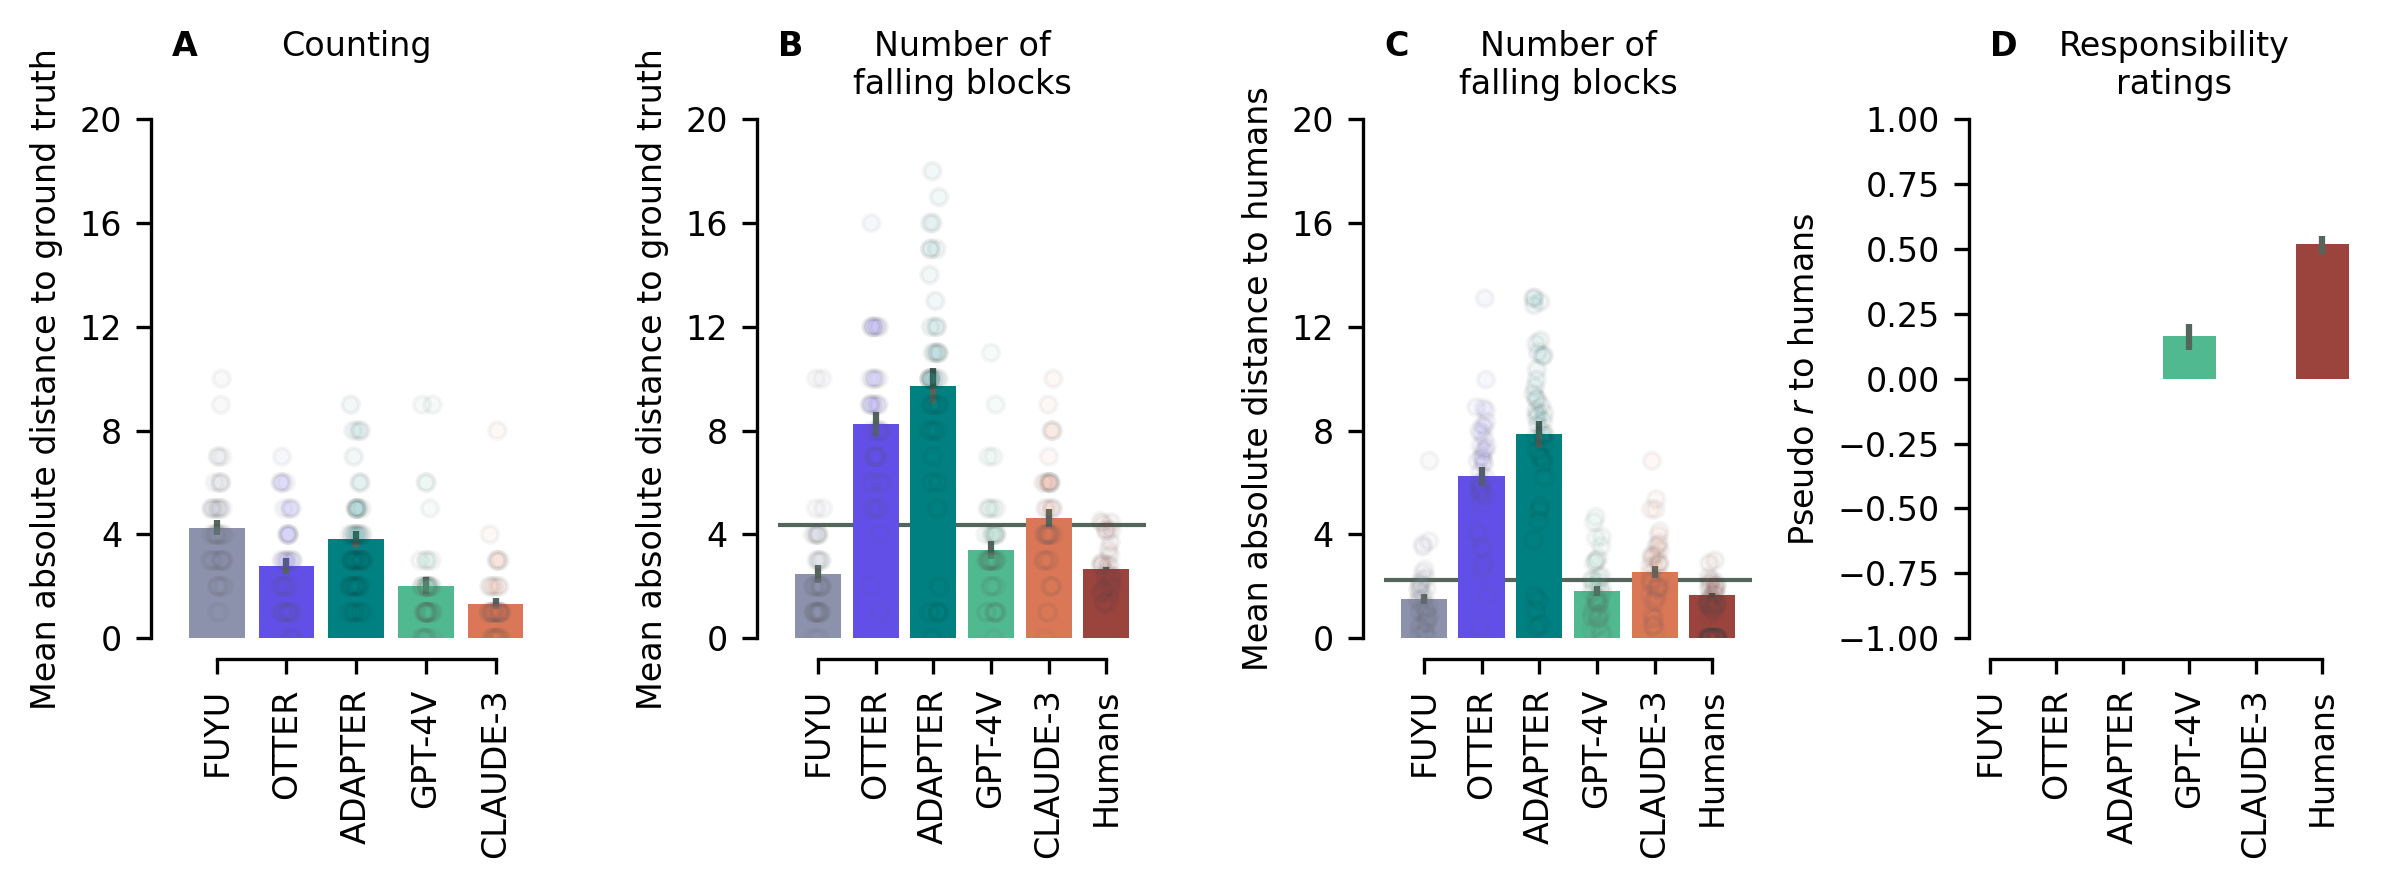

In [208]:
# Init plotting params
model_colors = plot_params()
col_dict = dict(zip([0, 1, 2, 3, 4, 5], model_colors))

# Prepare plot
num_subjects = len(subjects)
fig, axs = plt.subplots(1, 4, figsize=(8,3), sharey=False, tight_layout=True)  

# Plot A
axs[0].bar(np.arange(num_subjects), counting, color=model_colors)
axs[0].set_title("Counting\n")
axs[0].set_title("A\n", fontweight='bold', loc='left', fontsize='medium')
axs[0].set_ylabel("Mean absolute distance to ground truth")
axs[0].set_ylim(0, 19)
axs[0].set_yticks(np.arange(0, 21, 4))
#axs[0].axhline(y=random_dists[0])
axs[0].set_xticks(np.arange(num_subjects))

# Plot B
axs[1].bar(np.arange(num_subjects+1), falling_gt, color=model_colors)
axs[1].set_title("Number of\nfalling blocks", loc="center")
axs[1].set_title("B\n", fontweight='bold', loc='left', fontsize='medium')
axs[1].set_ylabel("Mean absolute distance to ground truth")
axs[1].set_ylim(0, 19)
axs[1].set_yticks(np.arange(0, 21, 4))
axs[1].axhline(y=baseline_gt, linewidth=1, zorder=0)
axs[1].set_xticks(np.arange(num_subjects+1))

# Plot B
axs[2].bar(np.arange(num_subjects+1), falling_human, color=model_colors)
axs[2].set_title("Number of\nfalling blocks", loc="center")
axs[2].set_title("C\n", fontweight='bold', loc='left', fontsize='medium')
axs[2].set_ylabel("Mean absolute distance to humans")
axs[2].set_ylim(0, 19)
axs[2].set_yticks(np.arange(0, 21, 4))
axs[2].axhline(y=baseline_human, linewidth=1, zorder=0)
axs[2].set_xticks(np.arange(num_subjects+1))

# Plot C human_judgement_correlation_ci
axs[3].bar(np.arange(num_subjects+1), jenga_lmer_coef, color=model_colors)
axs[3].errorbar(np.arange(num_subjects+1), jenga_lmer_coef, yerr=jenga_lmer_conf, ls="none")
axs[3].set_title("Responsibility\nratings", loc="center")
axs[3].set_title("D\n", fontweight='bold', loc='left', fontsize='medium')
axs[3].set_ylabel(f"Pseudo $r$ to humans")
axs[3].set_ylim(-1, 1)
axs[3].set_xticks(np.arange(num_subjects+1))

# Add data distribution for first three plots
col_dict.popitem()
sns.stripplot(data=pd.DataFrame(counting_errs_subj).T.melt(), x="variable", y="value", linewidth=1, edgecolor="gray",
              ax=axs[0], hue="variable", palette=col_dict, alpha=.05, legend=False, size=4)
col_dict = dict(zip([0, 1, 2, 3, 4, 5], model_colors))
sns.stripplot(data=fgt, x="variable", y="value", ax=axs[1], hue="variable", palette=col_dict, 
              linewidth=1, edgecolor="gray", alpha=.05, legend=False, size=4)
sns.stripplot(data=fhu, x="variable", y="value", ax=axs[2], hue="variable", palette=col_dict, 
              linewidth=1, edgecolor="gray", alpha=.05, legend=False, size=4)

# Add error bars
axs[0].errorbar(np.arange(num_subjects), counting, yerr=counting_errs, ls="none")
axs[1].errorbar(np.arange(num_subjects+1), falling_gt, yerr=falling_gt_errs, ls="none")
axs[2].errorbar(np.arange(num_subjects+1), falling_human, yerr=falling_human_errs, ls="none")

# Despine and set x tick labels afterwards
sns.despine(offset=5, trim=True)
axs[0].set_xticklabels(subjects, rotation=90)
axs[1].set_xticklabels(subjects + ["Humans"], rotation=90)
axs[2].set_xticklabels(subjects + ["Humans"], rotation=90)
axs[3].set_xticklabels(subjects + ["Humans"], rotation=90)
axs[0].set_xlabel("")
axs[1].set_xlabel("")
axs[2].set_xlabel("")
plt.savefig("figures/02_jenga_main.pdf", dpi=300)

#### Test if GPT4V is signficantly better than the Human Average for number of falling blocks (Plot 3B)

In [ ]:
gt = models[models["Experiment"] == 2]["GT"].values
gpt4v = models[models["Experiment"] == 2]["GPT-4V"].values
humans = human_prediction.groupby("trial").mean("response").response.values
index = human_prediction.groupby("trial").mean("response").index.values.astype(int) - 1

ttest_ind(abs(gpt4v[index] - gt[index]), abs(humans - gt[index]), nan_policy="omit")

## Example plots

In [ ]:
# Print images in order from easy to hard for humans 
human_mean = human_prediction.groupby("trial").mean("response").response
gt = human_prediction.groupby("trial").mean("response").nfall
human_inds_easyhard = np.argsort(abs(human_mean - gt))
human_imgs_easyhard = human_prediction.groupby("trial").mean("response").iloc[human_inds_easyhard].index.values
print(human_imgs_easyhard)

In [ ]:
# Print images in order from easy to hard for GPT4V
index = human_prediction.groupby("trial").mean("response").index.astype(int) - 1
gpt4v = models[models["Experiment"] == 2]["GPT-4V"].values
gpt4v_inds_easyhard = np.argsort(abs(gpt4v[index] - gt))
gpt4v_imgs_easyhard = human_prediction.groupby("trial").mean("response").iloc[gpt4v_inds_easyhard].index.values
print(gpt4v_imgs_easyhard)

In [ ]:
# Prepare plot
fig, axs = plt.subplots(2, 4, sharey=False, tight_layout=True, figsize=(6,4))  

# First column: easy for humans, hard for GPT4V (20, 2)
axs[0, 0].imshow(plt.imread("eval/images/jenga/initial_trial_20_diff_4_index_2.png"))
axs[0, 0].axis("off")
axs[1, 0].imshow(plt.imread("eval/images/jenga/initial_trial_2_diff_1_index_2.png"))
axs[1, 0].axis("off")

# Second column: easy for humans, easy for GPT4V (38, 31)
axs[0, 1].imshow(plt.imread("eval/images/jenga/initial_trial_38_diff_7_index_2.png"))
axs[0, 1].axis("off")
axs[1, 1].imshow(plt.imread("eval/images/jenga/initial_trial_31_diff_6_index_1.png"))
axs[1, 1].axis("off")

# Third column: hard for humans, hard for GPT4V (36, 40)
axs[0, 2].imshow(plt.imread("eval/images/jenga/initial_trial_36_diff_6_index_6.png"))
axs[0, 2].axis("off")
axs[1, 2].imshow(plt.imread("eval/images/jenga/initial_trial_40_diff_7_index_4.png"))
axs[1, 2].axis("off")

# Fourth column: hard for humans, easy for GPT4V (15, 18)
axs[0, 3].imshow(plt.imread("eval/images/jenga/initial_trial_15_diff_3_index_3.png"))
axs[0, 3].axis("off")
axs[1, 3].imshow(plt.imread("eval/images/jenga/initial_trial_18_diff_3_index_6.png"))
axs[1, 3].axis("off")

# Set column titles
axs[0, 0].set_title("Easy for humans\nHard for GPT4-V", fontweight="bold")
axs[0, 1].set_title("Easy for humans\nEasy for GPT4-V", fontweight="bold")
axs[0, 2].set_title("Hard for humans\nHard for GPT4-V", fontweight="bold")
axs[0, 3].set_title("Hard for humans\nEasy for GPT4-V", fontweight="bold")
plt.savefig("figures/02_jenga_examples.pdf", dpi=300)